In [11]:
%pylab inline
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [42]:
# Data import 

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    path = os.path.join(os.getcwd(), hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with open(path, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [43]:
# NN definition

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.lsm = nn.LogSoftmax(dim=1)
        
    def forward(self, x, **kwargs):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.lsm(x)
        return x

100%|██████████| 1000/1000 [00:00<00:00, 1525.58it/s]


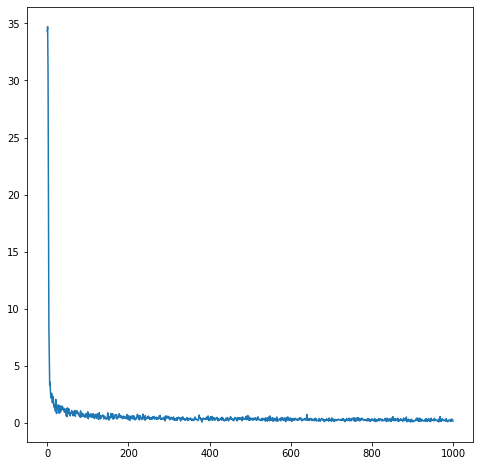

In [45]:
# NN instantiation

model = Classifier()
batch_size = 128
epochs = 1000
loss_function = nn.NLLLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0)

losses = [] # For later plotting

for i in trange(epochs):
    samples_idx = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[samples_idx].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samples_idx]).long()
    model.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot(losses)
    

In [46]:
out_test = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
accuracy = (out_test == Y_test).mean()
accuracy

0.9315

Prediction:  2
Actual value:  2


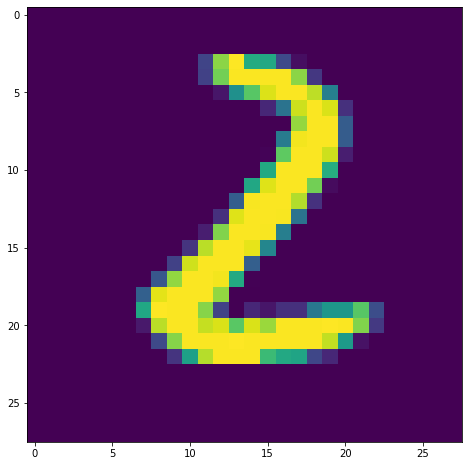

In [47]:
rand_idx = np.random.randint(0, X_test.shape[0])
imshow(X_test[rand_idx])
print('Prediction: ', out_test[rand_idx])
print('Actual value: ', Y_test[rand_idx])

In [48]:
### NO PYTORCH ALLOWED FROM HERE ON ###

In [49]:
# Helper functions

def dot(a, b):
    d = a.dot(b)
    if len(b.shape) == 3:
        if len(a.shape) == 2:
            d = d.swapaxes(0, 1)
        elif len(a.shape) == 3:
            assert a.shape[0] == b.shape[0]
            d = d.swapaxes(1, 2)[np.arange(a.shape[0]), np.arange(a.shape[0])]
    return d

In [84]:
# Layer function definition

import abc

class LayerFunction:
    __metaclass__ = abc.ABCMeta

    def __call__(self, x, **kwargs):
        return self.evaluate(x, **kwargs)
        
    @abc.abstractmethod
    def evaluate(self, x, **kwargs):
        pass
    
    @abc.abstractmethod
    def backprop(self, x, dD):
        pass


# Activation function definition

class ActivationFunction(LayerFunction):
    
    def __init__(self, axis=1):
        self.axis = axis
    

class ReLU(ActivationFunction):
    
    def evaluate(self, x, **kwargs):
        return np.maximum(x, 0)
    
    def backprop(self, x, dD):
        return (x > 0).astype(int)*dD


class LogSoftmax(ActivationFunction):
        
    def evaluate(self, x, **kwargs):
        if len(x.shape) == 2:
            x = x - x.max()
            x = x - np.log(np.exp(x).sum()).reshape(-1, 1)
        elif len(x.shape) == 3:
            x = x - x.max(1).reshape(-1, 1, 1)
            x = x - np.log(np.exp(x).sum(1)).reshape(-1, 1, 1)
        return x
            
    def backprop(self, dD, inputs=None, outputs=None):
        if outputs is not None:
            exp_lsm = np.exp(outputs)
        elif inputs is not None:
            exp_lsm = np.exp(self(inputs))
        dLSM = dD - exp_lsm*dD.sum(axis=self.axis)
        return dLSM
    

# Loss function definition

class LossFunction(LayerFunction):

    def __init__(self, axis=0):
        self.axis = axis #UNUSED
    

class NLLLoss(LossFunction):
    
    def evaluate(self, x, **kwargs):
        if self.axis == 0:
            return -np.average(x[np.arange(x.shape[0]), kwargs['labels']])
    
    def backprop(self, x, y):
        dx = np.zeros(x.shape, dtype=x.dtype)
        if self.axis == 0:
            dx[np.arange(x.shape[0]), y.T] = -1
        return dx

In [85]:
# Model definition

class NPClassifier:
    def __init__(self, uniform=True, with_biases=False, dtype=np.float32):
        self.with_biases = with_biases
        
        # Kaiming weigth initialization
        if uniform:
            # Uniform sampling
            # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
            self.w1 = np.random.uniform(-1., 1., size=(28*28, 128))/np.sqrt(28*28*128).astype(dtype)
            self.w2 = np.random.uniform(-1., 1., size=(128, 10))/np.sqrt(128*10).astype(dtype)
        else:
            # Normal sampling 
            # https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
            self.w1 = np.random.randn(28*28, 128)/np.sqrt(1/(28*28*128)).astype(dtype)
            self.w2 = np.random.randn(128, 10)/np.sqrt(1/128*10).astype(dtype)
            
        if with_biases:
            # Uniform bias initialization
            # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L44-L48
            self.b1 = np.random.uniform(-1., 1., size=(1, 128))/np.sqrt(128).astype(dtype)
            self.b2 = np.random.uniform(-1., 1., size=(1, 10))/np.sqrt(10).astype(dtype)
        
        # Layer activation functions
        self.act1 = ReLU()
        self.act2 = LogSoftmax()
    
    def __call__(self, x):
        return self.forward(x)
    
    @classmethod
    def from_weights(cls, w1, w2, b1=None, b2=None):
        assert w1.shape == (28*28, 128) and w2.shape == (128, 10)
        classifier = cls()
        classifier.w1 = w1
        classifier.w2 = w2
        if b1 is not None and b2 is not None:
            assert b1.shape == (1, 128) and b2.shape == (1, 10)
            classifier.with_biases = True
            classifier.b1 = b1
            classifier.b2 = b2
        return classifier
        
    def forward(self, x):
        x = x.dot(self.w1)
        if self.with_biases:
            x = x + self.b1
        x = self.act1(x)
        x = x.dot(self.w2)
        if self.with_biases:
            x = x + self.b2
        x = self.act2(x)
        return x
    
    def forward_backward(self, x, y, loss_function):
                    
        # Forward pass
        z1 = x.dot(self.w1)
        if self.with_biases:
            z1 = z1 + self.b1
        a1 = self.act1(z1)
        z2 = a1.dot(self.w2)
        if self.with_biases:
            z2 = z2 + self.b2
        a2 = self.act2(z2)
        loss = loss_function(a2, labels=y)
                
        # Backward pass
        da2 = loss_function.backprop(a2, y)
        dz2 = self.act2.backprop(z2, da2)
        db2 = dz2 # Relevant (returns only if with_biases)
        dw2 = a1.T.dot(dz2) # Relevant
        da1 = dz2.dot(w2.T)
        dz1 = self.act1.backprop(z1, da1)
        db1 = dz1 # Relevant (returns only if with_biases)
        dw1 = x.T.dot(dz1) # Relevant
        
        # Return loss and gradients
        return loss, dw1, dw2, db1, db2
    
    def step(self, lr, dw1, dw2, db1=None, db2=None):
        self.w1 = self.w1 - dw1 * lr
        self.w2 = self.w2 - dw2 * lr
        if self.with_biases:
            self.b1 = self.b1 - db1 * lr
            self.b2 = self.b2 - db2 * lr
    
    def train(self, inputs, labels, batch_size, epochs, loss_function, learning_rate):
        losses = []
        for i in (t := trange(epochs)):
            samples = np.random.randint(0, inputs.shape[0], size=batch_size)
            loss, dw1, db1, dw2, db2 = self.forward_backward(inputs[samples], labels[samples], loss_function)
            losses.append(loss)
            self.step(dw1, db1, dw2, db2, learning_rate)
        return losses
    
    def test(self, inputs, labels):
        forward = np.argmax(self.forward(inputs.reshape((-1, 28*28))), 1).reshape(-1, 1)
        return (forward == labels.reshape(-1, 1)).mean()

In [86]:
### PYTORCH V. PYTHON COMPARISON ###

In [87]:
# Model comparison

# Copy Classifier data into NPClassifier
w1 = model.l1.weight.detach().numpy().T
b1 = model.l1.bias.detach().numpy().reshape((-1, 128))
w2 = model.l2.weight.detach().numpy().T
b2 = model.l2.bias.detach().numpy().reshape((-1, 10))
npmodel = NPClassifier.from_weights(w1, w2, b1, b2)

# Compare predictions
n = 20
samples_idx = np.random.randint(0, X_test.shape[0], size=n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped), 0)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

# Gradient of PyTorch trained weights and biases is near 0
loss_function = NLLLoss()
nploss, dw1, db1, dw2, db2 = npmodel.forward_backward(X_test_reshaped, Y_test[samples_idx], loss_function)
print('\nGradient averages \ndw1: ', np.average(dw1), 'db1: ', np.average(db1), 'dw2: ', np.average(dw2), 'db2: ', np.average(db2), '\n')

# Gradient equivalence
model.zero_grad()
out = model(torch.tensor(X_test_reshaped).float())
loss_function = nn.NLLLoss(reduction='none')
loss = loss_function(out, torch.tensor(Y_test[samples_idx]).long())
loss = loss.mean()
print(loss, nploss)
loss.backward()

Y_train[samples_idx].shape
# figsize(8, 8)
# imshow(np.average(dw1, axis=0).reshape(256, 28*14))
# figure()
# imshow(model.l1.weight.grad.detach().numpy().reshape(256, 28*14))

PyTorch:  [1 6 1 6 2 7 7 8 3 4 7 3 0 4 8 1 3 0 3 6]
Python:   [12  2  2 18 13 13  1  6  7 13]
Labels:   [1 6 1 6 2 7 7 8 3 9 7 3 0 4 3 1 3 0 3 2]


ValueError: operands could not be broadcast together with shapes (20,10) (20,) 

  0%|          | 0/10 [00:00<?, ?it/s]

X shape: (64, 784)


 10%|█         | 1/10 [00:06<00:58,  6.55s/it]

X shape: (64, 784)


 20%|██        | 2/10 [00:13<00:52,  6.56s/it]

X shape: (64, 784)


 30%|███       | 3/10 [00:19<00:45,  6.55s/it]

X shape: (64, 784)


 40%|████      | 4/10 [00:26<00:39,  6.55s/it]

X shape: (64, 784)


 50%|█████     | 5/10 [00:32<00:32,  6.56s/it]

X shape: (64, 784)


 60%|██████    | 6/10 [00:39<00:26,  6.57s/it]

X shape: (64, 784)


 70%|███████   | 7/10 [00:46<00:19,  6.58s/it]

X shape: (64, 784)


 80%|████████  | 8/10 [00:52<00:13,  6.57s/it]

X shape: (64, 784)


 90%|█████████ | 9/10 [00:59<00:06,  6.55s/it]

X shape: (64, 784)


100%|██████████| 10/10 [01:05<00:00,  6.56s/it]


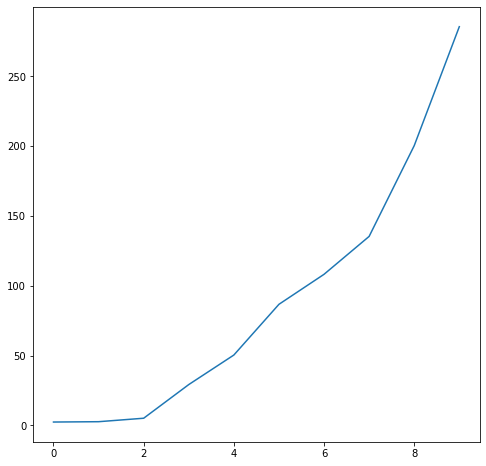

In [67]:
npmodel = NPClassifier()

batch_size = 64
epochs = 10
learning_rate = 0.001
loss_function = NLLLoss()

inputs = X_train.reshape(-1, 28*28)
labels = Y_train.reshape(-1, 1)

losses = npmodel.train(inputs, labels, batch_size, epochs, loss_function, learning_rate)

plot(losses)

PyTorch:  [3 5 6 2 4 4 7 1 3 2 5 6 7 8 1 4]
Python:   [8 5 0 2 4 9 9 1 2 2 5 0 7 8 1 4]
Labels:   [3 5 6 2 4 9 9 1 3 3 5 6 9 8 1 4]


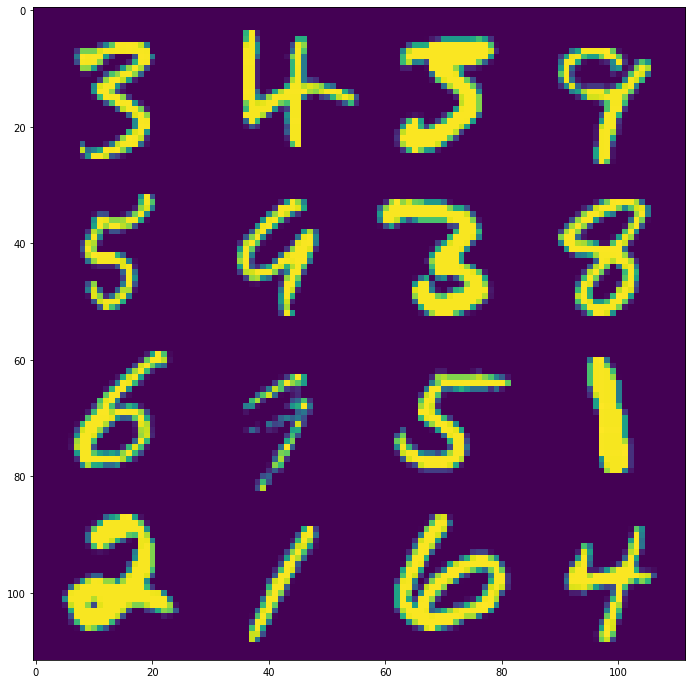

In [41]:
# Compare predictions
n = 4
samples_idx = np.random.randint(0, X_test.shape[0], size=n*n)
X_test_reshaped = X_test[samples_idx].reshape(-1, 28*28)
out_model = np.argmax(model(torch.tensor(X_test_reshaped).float()).detach().numpy(), 1)
out_npmodel = np.argmax(npmodel(X_test_reshaped.T), 0)

print('PyTorch: ', out_model)
print('Python:  ', out_npmodel)
print('Labels:  ', Y_test[samples_idx])

figsize(12, 12)
imshow(np.concatenate(X_test[samples_idx].reshape(n, 28*n, 28), axis=1))


In [42]:
npmodel.test(X_test, Y_test)

0.7527

In [31]:
dir(torch.device('cuda'))

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'index',
 'type']

In [36]:
torch.cuda.is_available()

False

In [3]:
a = np.random.uniform(-1., 1., size=(120, 28*28))/np.sqrt(28*28*120)


In [7]:
a.dtype

dtype('float64')

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'